In [2]:
import os
from typing import NamedTuple

import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from mediapipe.framework.formats.landmark_pb2 import NormalizedLandmarkList
from sklearn.model_selection import train_test_split

2023-05-08 17:32:31.549651: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-08 17:32:31.551025: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-08 17:32:31.580326: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-08 17:32:31.581035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 17:32:32.193986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.3,
    min_tracking_confidence=0.5,
)
mp_drawing = mp.solutions.drawing_utils

mp_drawing_styles = mp.solutions.drawing_styles
landmark_style = mp_drawing_styles.get_default_hand_landmarks_style()

connection_style = mp_drawing_styles.get_default_hand_connections_style()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
def dataset_files(dataset_dir: str = "../dataset/", class_size: int = 1_000) -> list[tuple[int, str]]:
    files_dataset = []
    for dir_label in sorted(os.listdir(dataset_dir)):
        dir_label_path = dataset_dir + dir_label
        if os.path.isfile(dir_label_path):
            continue
        dir_label_path += "/"
        index = int(dir_label.split("_")[0])
        files = os.listdir(dir_label_path)
        files_dataset.extend([(index, dir_label_path + img_path) for img_path in np.random.choice(files, size=class_size)])
    return files_dataset

In [4]:
def test_images():
    for key, value in files_dataest.items():
        image = cv2.imread(value[0])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    landmark_style,
                    connection_style,
                )
        plt.imshow(image)
        plt.title(key)
        plt.show()

In [6]:
files = dataset_files()
files[:5], len(files)

([(0, '../dataset/00_two_fingers_near/two_fingers_r_3020.jpg'),
  (0, '../dataset/00_two_fingers_near/two_fingers_r_3910.jpg'),
  (0, '../dataset/00_two_fingers_near/two_fingers_new_220.jpg'),
  (0, '../dataset/00_two_fingers_near/two_fingers_r_3010.jpg'),
  (0, '../dataset/00_two_fingers_near/two_fingers_r_810.jpg')],
 15000)

In [7]:
def process_image(filename: str, flip: bool = False) -> NamedTuple:
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if flip:
        image = cv2.flip(image, 1)

    results = hands.process(image)
    return results

In [10]:
def calc_landmark_list(landmarks: NormalizedLandmarkList) -> np.ndarray:
    landmark_list = landmarks.landmark
    # Get the position of the wrist landmark (Landmark.WRIST)
    wrist_position_x, wrist_position_y = (
        landmark_list[mp.solutions.hands.HandLandmark.WRIST].x,
        landmark_list[mp.solutions.hands.HandLandmark.WRIST].y,
    )

    # Normalize the landmarks relative to the wrist position
    normalized_landmarks = [
        (landmark.x - wrist_position_x, landmark.y - wrist_position_y) for landmark in landmark_list  # landmark.z
    ]
    normalized_landmarks = np.array(normalized_landmarks).flatten()
    normalized_landmarks /= max(abs(normalized_landmarks))
    return normalized_landmarks

In [25]:
def process(filename: str, flip: bool = False) -> np.ndarray:
    results = process_image(filename, flip)
    if results.multi_hand_landmarks is None:
        return None
    landmarks = results.multi_hand_landmarks[0]

    result = calc_landmark_list(landmarks)
    is_right = results.multi_handedness[0].classification[0].label == "Right"
    return np.append(result, is_right)

In [26]:
print(process(files[0][1]), process(files[0][1], True))
print(process('../dataset/00_two_fingers_near/two_fingers_330.jpg'), process('../dataset/00_two_fingers_near/two_fingers_330.jpg', True))

[ 0.          0.         -0.09108994 -0.07013608 -0.16226735 -0.18826263
 -0.16370438 -0.30643086 -0.11326423 -0.35294546 -0.14070626 -0.47972605
 -0.16051527 -0.68306383 -0.16610597 -0.81593122 -0.16721422 -0.93061366
 -0.07702803 -0.48882001 -0.10671674 -0.72692618 -0.12517311 -0.87649621
 -0.13708558 -1.         -0.00964219 -0.44985614 -0.05557525 -0.51586888
 -0.08901699 -0.41113038 -0.10246509 -0.32292676  0.04881893 -0.37189254
 -0.00723822 -0.41127767 -0.03419715 -0.32675657 -0.03712919 -0.2552798
  1.        ] [ 0.00000000e+00  0.00000000e+00  8.82367410e-02 -7.32094299e-02
  1.52807741e-01 -1.97662379e-01  1.50321118e-01 -3.12249886e-01
  1.04184200e-01 -3.71652497e-01  1.31257305e-01 -4.92204521e-01
  1.52823151e-01 -6.87989560e-01  1.59367021e-01 -8.15529377e-01
  1.62133096e-01 -9.23219920e-01  6.70674029e-02 -4.97099236e-01
  9.21135140e-02 -7.25474862e-01  1.13243735e-01 -8.79218310e-01
  1.26665750e-01 -1.00000000e+00  3.14450685e-03 -4.53801739e-01
  5.03675259e-02 -5.1

In [27]:
arr = []
for label, file_path in tqdm(dataset_files()):
    for flip in [True, False]:
        result = process(file_path, flip)
        if result is None:
            continue
        result = np.append(result, label)
        arr.append(result)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [28]:
arr = np.stack(arr)
arr[:2], arr.shape

(array([[ 0.        ,  0.        , -0.02073012,  0.01251257, -0.01488971,
         -0.06210118,  0.05229086, -0.1310778 ,  0.10287097, -0.19636181,
         -0.11460505, -0.39608297, -0.10615273, -0.57787052, -0.09256575,
         -0.69515564, -0.08139242, -0.77967842, -0.04954466, -0.45387538,
         -0.05530104, -0.65991424, -0.04441746, -0.83662005, -0.03400158,
         -1.        ,  0.01457347, -0.43077829,  0.06396782, -0.55090709,
          0.10078516, -0.47356861,  0.11824212, -0.4107787 ,  0.07195059,
         -0.37486167,  0.11483167, -0.42342169,  0.1233394 , -0.36425253,
          0.11607872, -0.31996134,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.0462213 ,  0.01096092,  0.03594167,
         -0.06883133, -0.03542832, -0.16611077, -0.10495063, -0.28017748,
          0.13484269, -0.39471971,  0.12856955, -0.61657443,  0.11436877,
         -0.77072136,  0.10447271, -0.90757746,  0.06116929, -0.44001756,
          0.06941837, -0.68409997,  0.05055166, -0

In [29]:
col_names = sum([[f"x{i}", f"y{i}"] for i in range(1, 22)], [])
col_names.extend(["is_right", "label"])

In [30]:
with open("processed.npy", "wb") as f:
    np.save(f, arr)

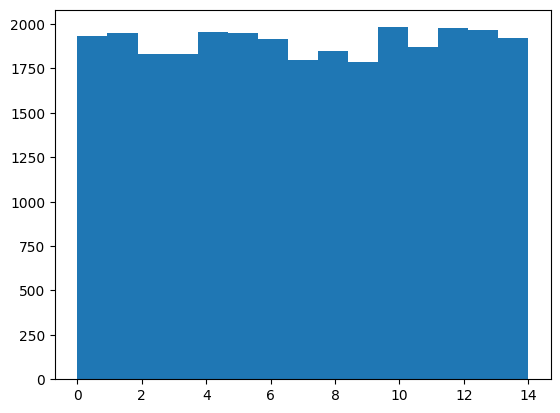

In [41]:
plt.hist([a[-1] for a in arr], bins=len(set(arr[:, -1])));

In [44]:
X_train, X_test, y_train, y_test = train_test_split(arr[:, :-1], arr[:, -1], test_size=0.2, stratify=arr[:, -1])
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22814, 43), (22814,), (5704, 43), (5704,))

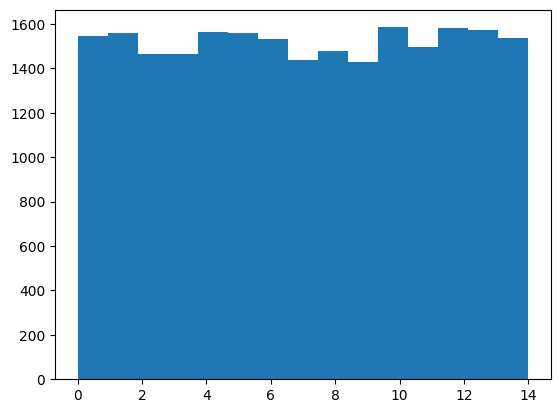

In [47]:
plt.hist(y_train, bins=len(set(y_train)));

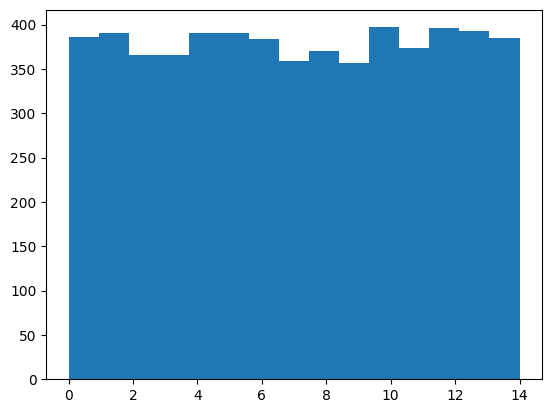

In [48]:
plt.hist(y_test, bins=len(set(y_test)));

In [4]:
arr = np.load("../data/processed.npy")

In [7]:
with open("processed.npz", "wb") as f:
    np.save(f, arr=arr)